In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
% precision 2
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import statsmodels.api as sm
from sklearn import preprocessing

## Exploratory Analysis & Notebook Building

#### References for Data

    HHI Data - http://www.psc.isr.umich.edu/dis/census/Features/tract2zip/
    Population Density Data - https://blog.splitwise.com/2014/01/06/free-us-population-density-and-unemployment-rate-by-zip-code/

### Data Dictionary

    1. CUSTDAYS  - Days between account registration and 
    2. FPDAYS    - Days between estimated_ship_date and first purchase date
    3. CHDays    - Days between estimated_ship-date and order's checkout
    4. ON        - Order Number - position of this order in a customer's order history
    5. clv_profit_1_year  - Projected profit contribution in first year since first purchase (combination of fir      
    6. clv_profit_10_year - Projected profit contribution in 10 years since first purchase
    7. FOP       - First order profit, including discounts
    8. FOPD
   
    

#### Import Data

In [2]:
cd = pd.read_csv('../Final/clv_validation_data_2016-08-26.csv', sep = ';')
hhi = pd.read_csv('../Final/hhi-by-zip.csv', sep = ',')
pden = pd.read_csv('../Final/pop-density-2010.csv', sep = ',')
cud = pd.read_csv('../Final/cud_2016-08-29.csv', sep = ';')
lud = pd.read_csv('../Final/lud_2016-08-29.csv', sep = ';')
fp = pd.read_csv('../Final/mp_clv_2016-08-17.csv', sep = ';')

## Feature Creation
#### Format Zip Codes & Dates

In [3]:
#Formatting Zip Codes
pden['Zip/ZCTA'] = pden['Zip/ZCTA'].astype(str).str.zfill(5)
hhi['Zip'] = hhi['Zip'].astype(str).str.zfill(5)
cd['zip_code5'] = cd['zip_code5'].astype(str).str.zfill(5)
lud['default_shipping_zip'] = lud['default_shipping_zip'].astype(str).str.zfill(5)

# Formatting Dates
cd_dt = ['first_trans_date','checkout_date','cancellation_date','estimated_ship_date']
cud_dt = ['first_trans_date','last_trans_date','sign_up_date']

for i in cd_dt:
    cd[i] = pd.to_datetime(cd[i])

for i in cud_dt:
    cud[i] = pd.to_datetime(cud[i]) 



#### Drop Redundant and Unnecessary Data 

In [4]:
hhi.columns = ['Zip','Median-HHI','Mean-HHI','Pop','HHI-M','HHI-A']


df = pd.merge(left = cd, right = hhi, how = 'left', left_on = 'zip_code5', right_on = 'Zip')
df = pd.merge(left = df, right = pden, how = 'left', left_on = 'zip_code5', right_on = 'Zip/ZCTA')
df = pd.merge(left = df, right = cud, how = 'left', left_on = 'user_id', right_on = 'user_id')
df = pd.merge(left = df, right = lud, how = 'left', left_on = 'user_id', right_on = 'user_id')
df = df.drop(labels = ['Zip/ZCTA','Zip','orders_next_1_year','orders_next_2_year','orders_next_3_year','orders_next_10_year',
                      'revenue_next_1_year','revenue_next_2_year','revenue_next_3_year','revenue_next_10_year',
                      'clv_profit_2_year','clv_profit_3_year','clv_profit_10_year_x','clv_profit_10_year_y',
                      'clv_profit_1_year_y', 'first_trans_date_y','email','email_address_y',
                       'last_checkout_was_recurring','sixteen_week_customer','email_acquisition_utm_source','last_shipped_order',
                       'last_action_taken','last_action','profit_next_1_year','profit_next_2_year','profit_next_3_year',
                       'profit_next_10_year','action_by','program_id','order_id','last_trans_date','brand_persona',
                       'brand_persona_1','brand_persona_2','brand_persona_3','brand_persona_4','brand_persona_5',
                      'clv_revenue_1_year','clv_revenue_2_year','clv_revenue_3_year','clv_revenue_10_year','Pop',
                       '2010 Population','Land-Sq-Mi','clv_profit_10_year','custora_churn_risk','is_purchaser',
                       'next_scheduled_order','shipment_id','warehouse_order_id','product_title','product_option_id',
                      ]
             , axis = 1)


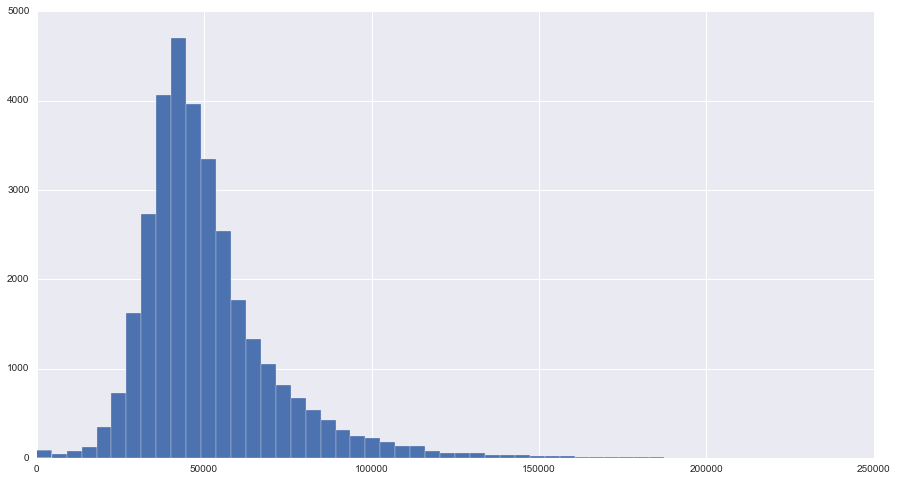

In [5]:
hhi['Median-HHI'].hist(figsize = (15,8),bins = 50)

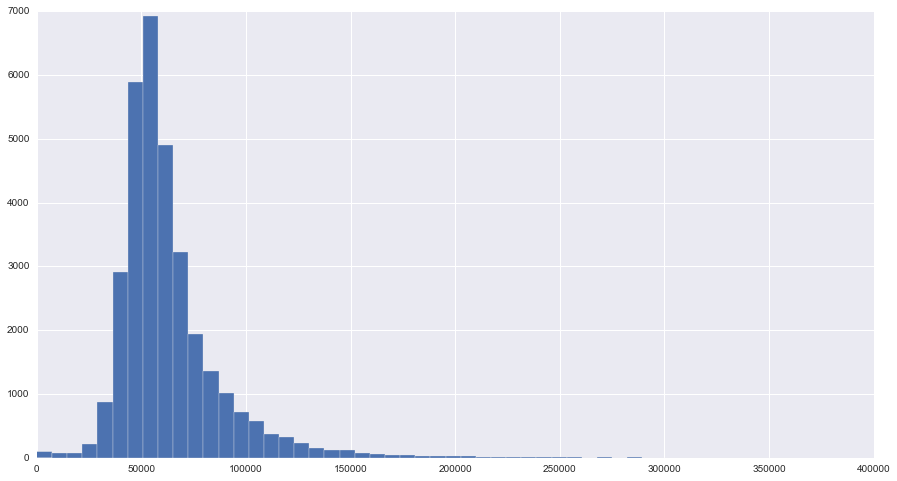

In [6]:
hhi['Mean-HHI'].hist(figsize = (15,8),bins = 50)

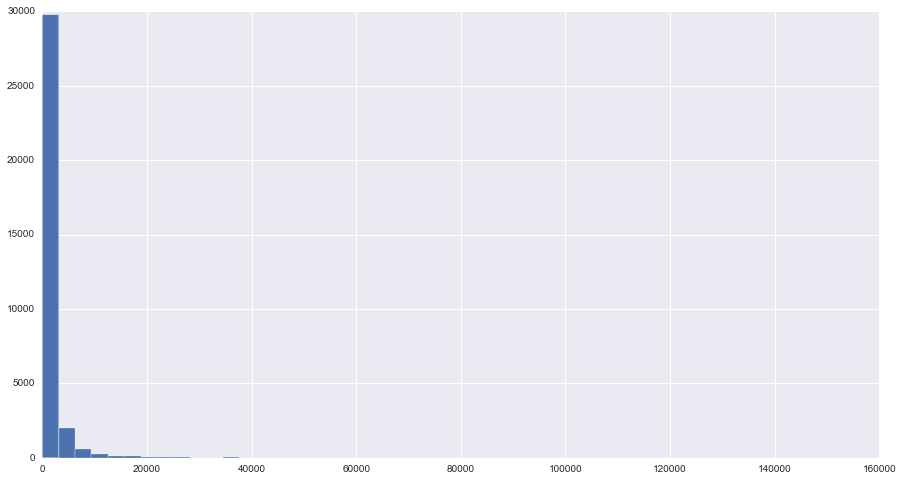

In [7]:
pden['Density Per Sq Mile'].hist(figsize = (15,8),bins = 50)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405133 entries, 0 to 405132
Data columns (total 56 columns):
user_id                             405133 non-null int64
email_address_x                     405133 non-null object
first_trans_date_x                  405004 non-null datetime64[ns]
checkout_date                       405133 non-null datetime64[ns]
new_customer                        405133 non-null object
type                                405133 non-null object
recurring_interval                  59134 non-null object
zip_code5                           405133 non-null object
state                               405133 non-null object
shipped_orders                      405133 non-null int64
cancellation_date                   25819 non-null datetime64[ns]
estimated_ship_date                 405133 non-null datetime64[ns]
category                            405080 non-null object
sub_category                        277214 non-null object
brand                              

In [9]:
df.dropna(0,'any',None,[['clv_profit_1_year_x','new_customer','type','order_revenue','first_purchase_revenue']],True)

#Dropping a few outliers
df=df[df['clv_profit_1_year_x']<=8000]

cols_to_keep = ['clv_profit_1_year_x','Median-HHI','Mean-HHI','HHI-M','HHI-A','P-Density','Density Per Sq Mile','new_customer','type',
                'recurring_interval','quantity','order_revenue','discount_amount','cogs','overhead','cart_brand',
                'first_purchase_revenue','first_purchase_profit','food_buyer','has_food_as','has_treats_as',
                'has_other_as','has_other_as','default_shipping_days_in_transit','first_coupon_category',
                'recent_puppy_purchaser']
df=df[cols_to_keep]
df['Mean-HHI'] = df['Mean-HHI'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395257 entries, 0 to 405132
Data columns (total 26 columns):
clv_profit_1_year_x                 395257 non-null float64
Median-HHI                          393878 non-null float64
Mean-HHI                            393878 non-null float64
HHI-M                               393878 non-null object
HHI-A                               393878 non-null object
P-Density                           394290 non-null object
Density Per Sq Mile                 394290 non-null float64
new_customer                        395257 non-null object
type                                395257 non-null object
recurring_interval                  59113 non-null object
quantity                            395257 non-null int64
order_revenue                       395257 non-null float64
discount_amount                     172741 non-null float64
cogs                                395257 non-null float64
overhead                            390145 non-null float6

In [10]:
df.replace([np.inf,-np.inf],np.nan,True)
df.fillna(0.0, inplace = True)

#tf = ['has_food_as','has_treats_as','has_other_as']

df.replace('t',1,True)
df.replace('f',0,True)
df.replace('One-time',0,True)
df.replace('Recurring',1,True)
df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 395257 entries, 0 to 405132
Data columns (total 26 columns):
clv_profit_1_year_x                 395257 non-null float64
Median-HHI                          395257 non-null float64
Mean-HHI                            395257 non-null float64
HHI-M                               395257 non-null object
HHI-A                               395257 non-null object
P-Density                           395257 non-null object
Density Per Sq Mile                 395257 non-null float64
new_customer                        395257 non-null int64
type                                395257 non-null int64
recurring_interval                  395257 non-null object
quantity                            395257 non-null int64
order_revenue                       395257 non-null float64
discount_amount                     395257 non-null float64
cogs                                395257 non-null float64
overhead                            395257 non-null float64

In [11]:
le = preprocessing.LabelEncoder()


df.new_customer = le.fit_transform(df.new_customer)
df.has_food_as = le.fit_transform(df.has_food_as)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395257 entries, 0 to 405132
Data columns (total 26 columns):
clv_profit_1_year_x                 395257 non-null float64
Median-HHI                          395257 non-null float64
Mean-HHI                            395257 non-null float64
HHI-M                               395257 non-null object
HHI-A                               395257 non-null object
P-Density                           395257 non-null object
Density Per Sq Mile                 395257 non-null float64
new_customer                        395257 non-null int64
type                                395257 non-null int64
recurring_interval                  395257 non-null object
quantity                            395257 non-null int64
order_revenue                       395257 non-null float64
discount_amount                     395257 non-null float64
cogs                                395257 non-null float64
overhead                            395257 non-null float64

#### Dummy Variables

In [12]:
dum_hhi_m = pd.get_dummies(data = df['HHI-M'],prefix = 'HHI-M', drop_first = True)
dum_hhi_a = pd.get_dummies(data = df['HHI-A'],prefix = 'HHI-A', drop_first = True)
dum_interval = pd.get_dummies(data = df['recurring_interval'],prefix = 'Interval', drop_first = True)
dum_pdens = pd.get_dummies(data = df['P-Density'],prefix = 'P-Density', drop_first = True)

In [13]:
df = df.join(dum_hhi_m)
df = df.join(dum_hhi_a)
df = df.join(dum_interval)
df= df.join(dum_pdens)
df.head()

,clv_profit_1_year_x,Median-HHI,Mean-HHI,HHI-M,HHI-A,P-Density,Density Per Sq Mile,new_customer,type,recurring_interval,...,P-Density_10-100,P-Density_100-500,P-Density_1000-2000,P-Density_100K+,P-Density_2000-4000,P-Density_4000-7500,"P-Density_50,000-75,000",P-Density_500-1000,"P-Density_75,000-100,000","P-Density_7500-10,000"
0,-7.72,39496.00,60453.00,$25-50K,$50-75K,2000-4000,3234.11,1,0,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1,61.58,32106.00,42516.00,$25-50K,$25-50K,4000-7500,6423.16,1,0,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,-8.00,46938.00,55059.00,$25-50K,$50-75K,"7500-10,000",8466.36,1,1,84 days,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,19.71,48011.00,61312.00,$25-50K,$50-75K,"50,000-75,000",52711.98,1,0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
4,50.93,110999.00,191408.00,$100-150K,$150-200K,"50,000-75,000",69094.41,1,1,70 days,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


In [14]:
df.drop(labels = ['HHI-M','HHI-A','recurring_interval','P-Density']
        , axis = 1, inplace = True)

In [15]:
#Creating this so I have only information I would have after first purchase
nc = df[df['new_customer'] == 1]


In [21]:
nc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167822 entries, 0 to 314518
Data columns (total 64 columns):
clv_profit_1_year_x                 167822 non-null float64
Median-HHI                          167822 non-null float64
Mean-HHI                            167822 non-null float64
Density Per Sq Mile                 167822 non-null float64
new_customer                        167822 non-null int64
type                                167822 non-null int64
quantity                            167822 non-null int64
order_revenue                       167822 non-null float64
discount_amount                     167822 non-null float64
cogs                                167822 non-null float64
overhead                            167822 non-null float64
cart_brand                          167822 non-null object
first_purchase_revenue              167822 non-null float64
first_purchase_profit               167822 non-null float64
food_buyer                          167822 non-null int6

In [29]:
train_cols = ['Median-HHI','Mean-HHI','Density Per Sq Mile',
                'quantity','order_revenue','discount_amount',
                'first_purchase_revenue','first_purchase_profit','food_buyer','has_food_as','has_treats_as',
                'has_other_as',
                '',recent_puppy_purchaser
,HHI-M_$100-150K
,HHI-M_$150-200K
,HHI-M_$200-250K
'',HHI-M_$25-50K
'',HHI-M_$25K or Less
'',HHI-M_$50-75K
'',HHI-M_$75-100K
'',HHI-A_$100-150K
'',HHI-A_$150-200K
'',HHI-A_$200-250K
'',HHI-A_$25-50K
'',HHI-A_$250K+
'',HHI-A_$25K or Less
'',HHI-A_$50-75K
'',HHI-A_$75-100K
'',Interval_105 days
'',Interval_112 days
'',Interval_14 days
'',Interval_21 days
'',Interval_28 days
'',Interval_35 days
'',Interval_42 days
'',Interval_49 days
'',Interval_56 days
'',Interval_63 days
'',Interval_70 days
'',Interval_77 days
'',Interval_84 days
'',Interval_91 days
'',Interval_98 days
'',P-Density_10 or less
'',P-Density_10,000-50,000
'',P-Density_10-100
'',P-Density_100-500
'',P-Density_1000-2000
'',P-Density_100K+
'',P-Density_2000-4000
'',P-Density_4000-7500
'',P-Density_50,000-75,000
'',P-Density_500-1000
'',P-Density_75,000-100,000
'',P-Density_7500-10,000]

In [ ]:
'recurring_interval',

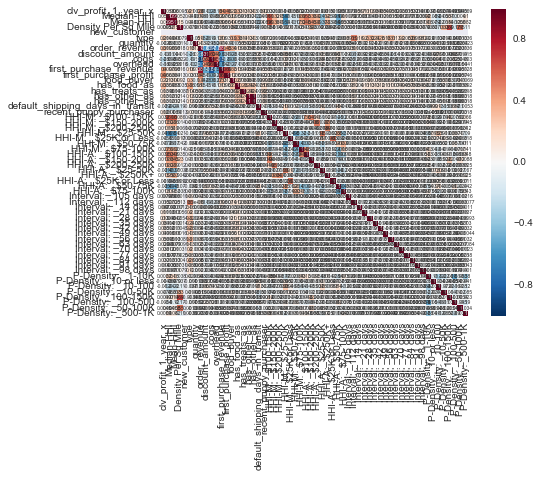

In [28]:
sns.heatmap(nc.corr(), square=True, annot=True, annot_kws={'size': 5});

In [28]:
#sns.clustermap(nc.corr(), annot=True);

In [32]:
train_cols = ['Density Per Sq Mile',
                'quantity','order_revenue','discount_amount',
                'first_purchase_revenue','first_purchase_profit','food_buyer','has_food_as','has_treats_as',
                'has_other_as',
                'recent_puppy_purchaser','HHI-M: _$100-150K',
'HHI-M: _$150-200K',
'HHI-M: _$200-250K',
'HHI-M: _$25-50K',
'HHI-M: _$25K or Less',
'HHI-M: _$50-75K',
'HHI-M: _$75-100K',
'HHI-A: _$100-150K',
'HHI-A: _$150-200K',
'HHI-A: _$200-250K',
'HHI-A: _$25-50K',
'HHI-A: _$250K+',
'HHI-A: _$25K or Less',
'HHI-A: _$50-75K',
'HHI-A: _$75-100K',
'Interval: _105 days',
'Interval: _112 days',
'Interval: _14 days',
'Interval: _21 days',
'Interval: _28 days',
'Interval: _35 days',
'Interval: _42 days',
'Interval: _49 days',
'Interval: _56 days',
'Interval: _63 days',
'Interval: _70 days',
'Interval: _77 days',
'Interval: _84 days',
'Interval: _91 days',
'Interval: _98 days',
'P-Density: _1-10K',
'P-Density: _10 or less',
'P-Density: _10-100',
'P-Density: _10-50K',
'P-Density: _100-150K',
'P-Density: _100-500',
'P-Density: _50-100K',
'P-Density: _500-1K']
train = nc[train_cols]
train.describe()

,Density Per Sq Mile,quantity,order_revenue,discount_amount,first_purchase_revenue,first_purchase_profit,food_buyer,has_food_as,has_treats_as,has_other_as,...,Interval: _91 days,Interval: _98 days,P-Density: _1-10K,P-Density: _10 or less,P-Density: _10-100,P-Density: _10-50K,P-Density: _100-150K,P-Density: _100-500,P-Density: _50-100K,P-Density: _500-1K
count,167822.00,167822.00,167822.00,167822.00,167822.00,167822.00,167822.00,167822.00,167822.00,167822.00,...,167822.00,167822.00,167822.00,167822.00,167822.00,167822.00,167822.00,167822.00,167822.00,167822.00
mean,3768.89,4.83,79.53,-7.13,69.34,9.85,0.63,0.11,0.02,0.01,...,0.00,0.00,0.50,0.01,0.09,0.05,0.00,0.21,0.01,0.13
std,10711.11,8.99,65.91,11.80,52.05,22.97,0.48,0.32,0.14,0.12,...,0.04,0.06,0.50,0.11,0.29,0.21,0.06,0.40,0.09,0.33
min,0.00,1.00,0.99,-553.89,0.00,-515.64,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,335.77,1.00,35.98,-10.49,36.94,0.07,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1340.19,2.00,63.48,-2.84,57.13,5.57,1.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,3453.65,4.00,99.93,0.00,84.58,13.58,1.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,144220.45,290.00,2213.58,0.00,1851.24,1130.30,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [31]:
y = nc.clv_profit_1_year_x
X = sm.add_constant(train)
model = sm.OLS(endog=y, exog=X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     clv_profit_1_year_x   R-squared:                       0.344
Model:                             OLS   Adj. R-squared:                  0.344
Method:                  Least Squares   F-statistic:                     1834.
Date:                 Thu, 01 Sep 2016   Prob (F-statistic):               0.00
Time:                         11:30:11   Log-Likelihood:            -9.6067e+05
No. Observations:               167822   AIC:                         1.921e+06
Df Residuals:                   167773   BIC:                         1.922e+06
Df Model:                           48                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                    -15.6180      3.472     -4.498      0.000       -22.424    -8.812
Density Per Sq Mile     -7.22e-05   6.08e-05     -1.187      0.235        -0.000   4.7e-05
quantity                  -0.0221      0.021     -1.066      0.287        -0.063     0.019
order_revenue              0.0993      0.007     14.536      0.000         0.086     0.113
discount_amount            0.6311      0.021     30.717      0.000         0.591     0.671
first_purchase_revenue     0.0858      0.010      8.498      0.000         0.066     0.106
first_purchase_profit      1.5393      0.012    123.964      0.000         1.515     1.564
food_buyer                10.9629      0.431     25.459      0.000        10.119    11.807
has_food_as               63.0946      0.670     94.156      0.000        61.781    64.408
has_treats_as             17.6066      1.351     13.034      0.000        14.959    20.254
has_other_as              12.6737      0.809     15.668      0.000        11.088    14.259
has_other_as              12.6737      0.809     15.668      0.000        11.088    14.259
recent_puppy_purchaser    35.3866      1.404     25.205      0.000        32.635    38.138
HHI-M: _$100-150K          1.7860      3.550      0.503      0.615        -5.171     8.743
HHI-M: _$150-200K         -1.8000      4.228     -0.426      0.670       -10.086     6.486
HHI-M: _$200-250K          7.7901      7.824      0.996      0.319        -7.545    23.125
HHI-M: _$25-50K            2.1774      3.555      0.613      0.540        -4.790     9.145
HHI-M: _$25K or Less       1.7462      4.270      0.409      0.683        -6.622    10.114
HHI-M: _$50-75K            2.3087      3.537      0.653      0.514        -4.623     9.240
HHI-M: _$75-100K           1.9840      3.535      0.561      0.575        -4.945     8.913
HHI-A: _$100-150K          1.4391      3.141      0.458      0.647        -4.717     7.595
HHI-A: _$150-200K          1.7017      3.286      0.518      0.605        -4.738     8.142
HHI-A: _$200-250K          6.6829      3.609      1.852      0.064        -0.391    13.757
HHI-A: _$25-50K           -1.0817      3.197     -0.338      0.735        -7.348     5.185
HHI-A: _$250K+             6.9830      4.558      1.532      0.126        -1.950    15.916
HHI-A: _$25K or Less       0.1188      5.615      0.021      0.983       -10.886    11.123
HHI-A: _$50-75K           -0.1113      3.152     -0.035      0.972        -6.289     6.067
HHI-A: _$75-100K           0.2598      3.145      0.083      0.934        -5.904     6.424
Interval: _105 days      -10.3373      4.381     -2.360      0.018       -18.923    -1.751
Interval: _112 days       -6.2868      0.864     -7.276      0.000        -7.980    -4.593
Interval: _14 days        73.3442      2.512     29.197      0.000   

##### Show the key descriptive statistics for all variables

##### Take a closer look at individual variables to understand their characteristics

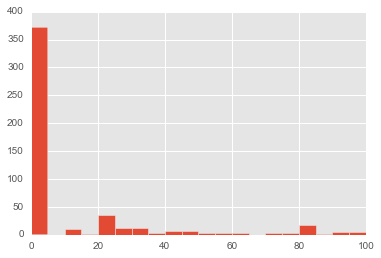

In [275]:
df.ZN.hist(bins=20);

In [276]:
df.CRIM.value_counts().sort_index()

0.01     1
0.01     1
0.01     1
0.01     1
0.01     1
0.01     1
0.01     1
0.01     1
0.01     1
0.02     2
0.02     1
0.02     1
0.02     1
0.02     1
0.02     1
0.02     1
0.02     1
0.02     1
0.02     1
0.02     1
0.02     1
0.03     1
0.03     1
0.03     1
0.03     1
        ..
15.87    1
16.81    1
17.87    1
18.08    1
18.50    1
18.81    1
19.61    1
20.08    1
20.72    1
22.05    1
22.60    1
23.65    1
24.39    1
24.80    1
25.05    1
25.94    1
28.66    1
37.66    1
38.35    1
41.53    1
45.75    1
51.14    1
67.92    1
73.53    1
88.98    1
Name: CRIM, dtype: int64

##### What can you learn from these metrics about the distribution of the variables?

##### Answer:

##### Standardize the data

In [5]:
df_std = df.apply(lambda x: (x-x.mean())/(x.std()), axis=1)

##### Visualize the distribution of the standardized data using [sns.violinplot](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.violinplot.html#seaborn.violinplot)

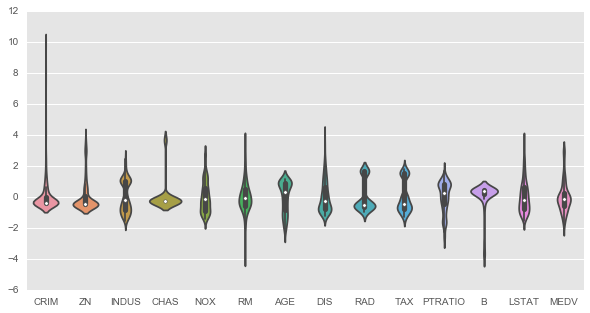

In [278]:
plt.figure(figsize=(10,5))
sns.violinplot(data=df_std);

##### Use [sns.pairplot](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html#seaborn-pairplot) to view (selected) pairwise correlations

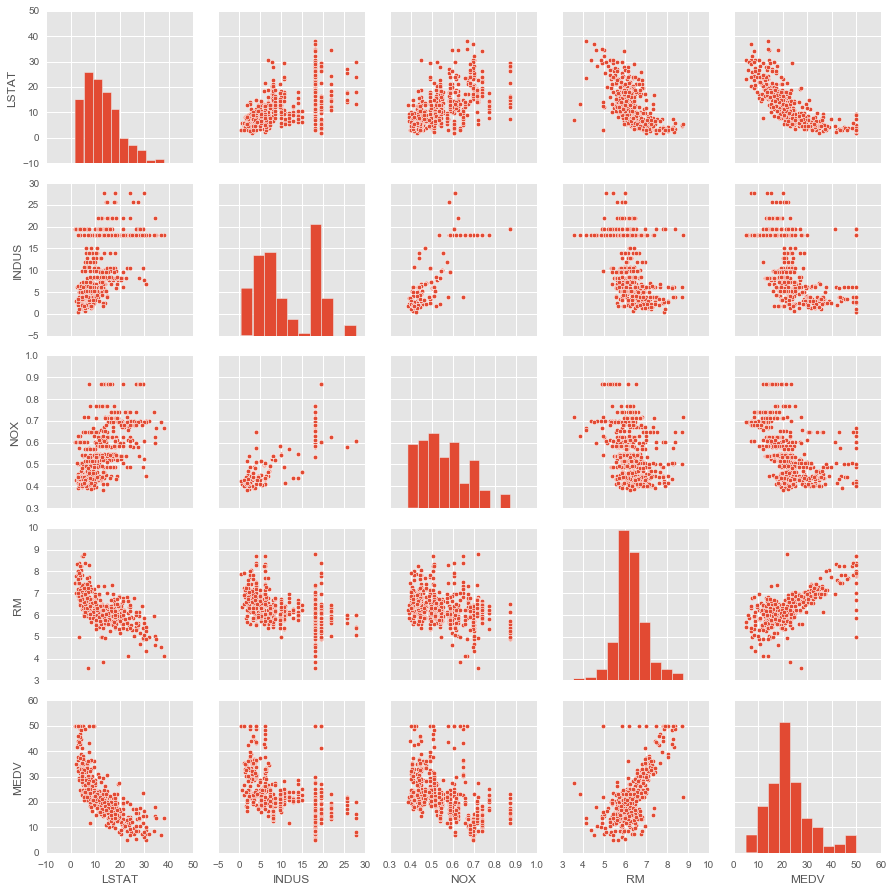

In [279]:
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5);

##### Use [sns.heatmap](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html) to plot the correlation matrix as heatmap (see alternatives [here](https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html) and [here](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.clustermap.html)). Make sure to show the coefficients!

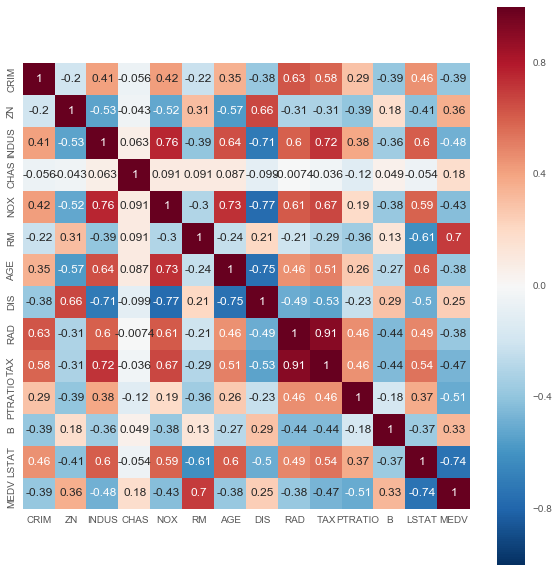

In [280]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), square=True, annot=True, annot_kws={'size': 12});

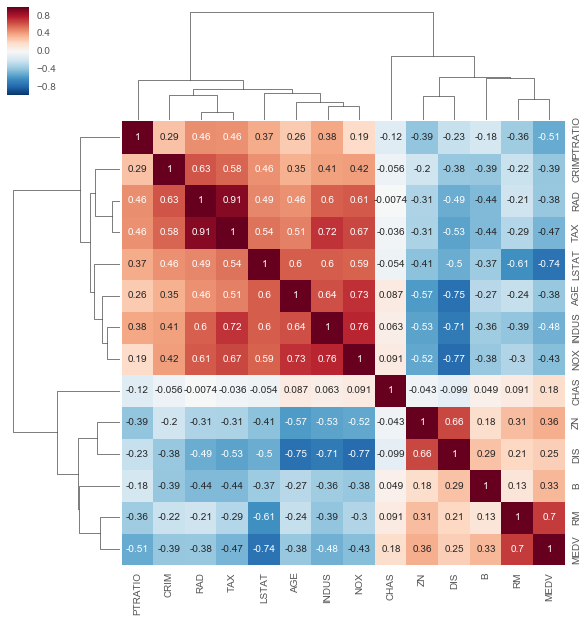

In [281]:
sns.clustermap(df.corr(), annot=True);

##### What did you learn?

##### Run a linear regression using `statsmodels`

In [6]:
y = df.MEDV
X = sm.add_constant(df.drop('MEDV', axis=1))
model = sm.OLS(endog=y, exog=X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 02 Aug 2016   Prob (F-statistic):          6.72e-135
Time:                        21:15:05   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.000        26.432    46.487
CRIM          -0.1080      0.033     -3.287      0.001        -0.173    -0.043
ZN             0.0464      0.014      3.382      0.001         0.019     0.073
INDUS          0.0206      0.061      0.334      0.738        -0.100     0.141
CHAS           2.6867      0.862      3.118      0.002         0.994     4.380
NOX          -17.7666      3.820     -4.651      0.000       -25.272   -10.262
RM             3.8099      0.418      9.116      0.000         2.989     4.631
AGE            0.0007      0.013      0.052      0.958        -0.025     0.027
DIS           -1.4756      0.199     -7.398      0.000        -1.867    -1.084
RAD            0.3060      0.066      4.613      0.000         0.176     0.436
TAX           -0.0123      0.004     -3.280      0.001        -0.020    -0.005
PTRATIO       -0.9527      0.131     -7.283      0.000        -1.210    -0.696
B              0.0093      0.003      3.467      0.001         0.004     0.015
LSTAT         -0.5248      0.051    -10.347      0.000        -0.624    -0.425
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Optional: Expore [sns.coefplot](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.coefplot.html#seaborn.coefplot) for a quick visualization of the coefficients. 

In [8]:
' + '.join(sm.add_constant(X).columns)

'const + CRIM + ZN + INDUS + CHAS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT'

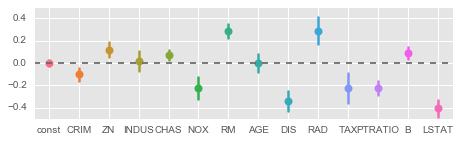

In [91]:
sns.coefplot(data=sm.add_constant(df_std), formula='{} ~ {}'.format(y.name, ' + '.join(sm.add_constant(X).columns)))

##### Examine the model residuals: get key distribution metrics, plot histogram

DescribeResult(nobs=506, minmax=(-15.594473899695039, 26.199270977908519), mean=9.083993987415194e-14, variance=21.938187283079166, skewness=1.520713045984652, kurtosis=5.281482435907607)


0.00

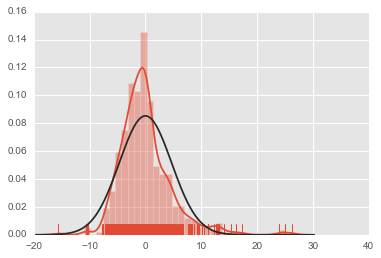

In [92]:
from scipy.stats import norm, normaltest, describe
sns.distplot(result.resid, fit=norm, rug=True);
print describe(result.resid)
stat, p = normaltest(result.resid)
p

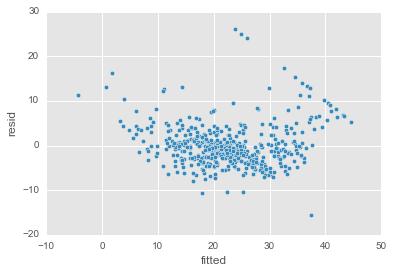

In [93]:
results = pd.DataFrame({'resid': result.resid, 'fitted': result.predict()})
results.plot.scatter(x='fitted', y='resid');

##### Optional: explore the statsmodels [regression diagnostics](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/regression_diagnostics.html)

##### Optional: Partial Regression Analysis

In [99]:
y = df['MEDV']
X = sm.add_constant(df.drop(['CRIM', 'MEDV'], axis=1))
model_1 = OLS(endog=y, exog=X).fit()

In [100]:
model_2 = OLS(endog=df['CRIM'], exog=X).fit()

In [104]:
model_3 = OLS(endog=model_1.resid, exog=sm.add_constant(pd.Series(model_2.resid, name='CRIM'))).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     11.06
Date:                Sun, 31 Jul 2016   Prob (F-statistic):           0.000944
Time:                        17:09:38   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3002.
Df Residuals:                     504   BIC:                             3010.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       2.444e-14      0.208   1.17e-13      1.000        -0.409     0.409
CRIM          -0.1080      0.032     -3.326      0.001        -0.172    -0.044
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                         6.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
partial_regression = pd.concat([df[['MEDV', 'CRIM']], pd.DataFrame({'resid': model_3.resid, 'fitted': model_3.predict()})], axis=1)

In [55]:
partial_regression.head()

,MEDV,CRIM,fitted,resid
0,24.00,0.01,-0.21,-3.43
1,21.60,0.03,-0.17,-1.72
2,34.70,0.03,-0.28,2.58
3,33.40,0.03,-0.28,3.36
4,36.20,0.07,-0.22,5.08


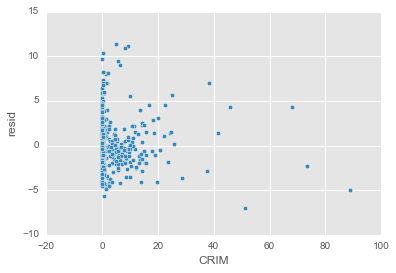

In [107]:
partial_regression.plot.scatter(x='CRIM', y='resid')

##### Linear Regression using Scikit Learn 

Estimate the mean squared prediction error using sklearn & 5-fold cross validation

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score

linear_regression = LinearRegression()
X = df.drop('MEDV', axis=1) 
y = df['MEDV']

lr_mse = -cross_val_score(estimator=linear_regression, 
                         X=X, y=y, cv=5, scoring='mean_squared_error')
np.mean(lr_mse)

37.13

##### Compare with Lasso & Ridge, using 5-fold CV to optimize regularization

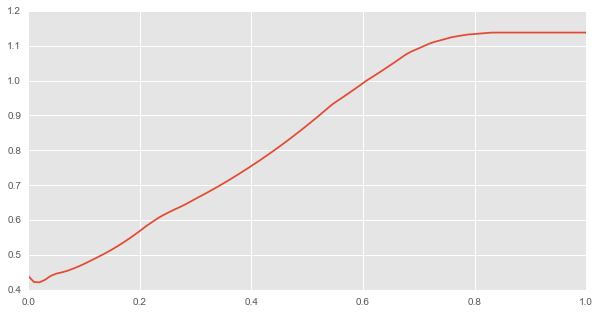

In [187]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import scale
alphas = np.linspace(0.0000001, 1, 100)
model = LassoCV(cv=5, alphas=alphas).fit(X=scale(X), y=scale(y))
mse_path = np.mean(model.mse_path_, axis=1)
plt.figure(figsize=(10,5))
plt.plot(model.alphas_, mse_path);

##### Optional: explore sklearn.linear_model.lasso_path

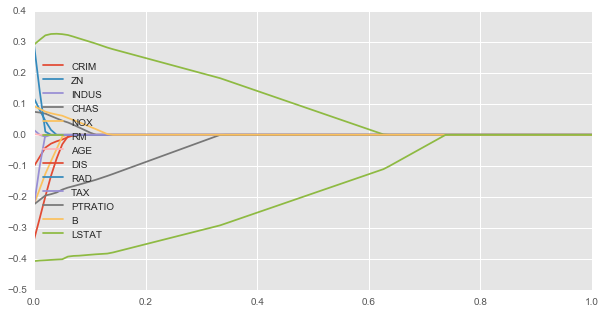

In [189]:
from sklearn.linear_model import lasso_path
alphas, coefs, _ = lasso_path(X=scale(X), y=scale(y), alphas=alphas)
coef_path = pd.DataFrame(data=coefs.T, index=alphas, columns=X.columns)
coef_path.sort_index().plot(figsize=(10,5));

##### Ridge Regression: Find optimal regularization parameter and corresponding MSE score

In [252]:
from sklearn.linear_model import Ridge

alphas = np.logspace(-2, 3, 100)
model = Ridge()

score, coefs = {}, {}
for a in alphas:
    model.set_params(alpha=a)
    mse = -cross_val_score(estimator=model, 
                         X=X, y=y, cv=5, scoring='mean_squared_error')
    score[a] = [np.mean(mse), np.std(mse)]
    model.fit(X, y)
    coefs[a] = model.coef_

mse    29.75
sd     12.47
-2sd    4.82
+2sd   54.69
Name: 155.567614393, dtype: float64

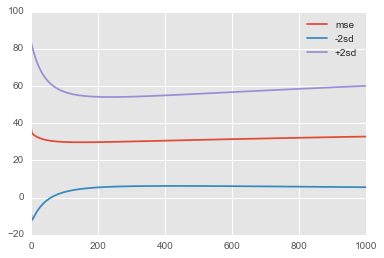

In [253]:
result = pd.DataFrame.from_dict(score).T
result.columns = ['mse', 'sd']
result['-2sd'] = result.mse - 2 * result.sd
result['+2sd'] = result.mse + 2 * result.sd
result.drop('sd', axis=1).plot();
result.loc[result.mse.idxmin()]

##### Optional: Show ridge coefficient path and optimal coefficients

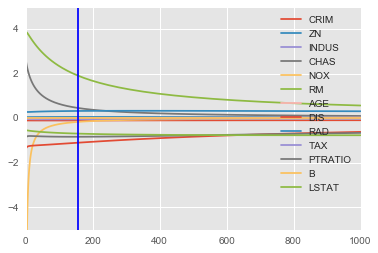

In [256]:
df = pd.DataFrame.from_dict(coeffs).T
df.columns = X.columns
df.plot(ylim=[-5, 5])
plt.axvline(result.mse.idxmin());

##### Find the optimal alpha and L1 ratio for the ElasticNet model

In [345]:
from sklearn.linear_model import ElasticNetCV

alphas = np.linspace(0.01, 10, 100)
l1_ratio = np.linspace(0.01, 0.05, 20)
model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratio, cv=5).fit(X, y)
mse = np.mean(model.mse_path_, axis=2)
net_result = pd.DataFrame(data=mse, columns=alphas, index=l1_ratio)
min_alpha = net_result.min(axis=0).idxmin()
min_l1_ratio = net_result.min(axis=1).idxmin()
min_alpha, min_l1_ratio, net_result.min().min()

(9.60, 0.01, 29.78)

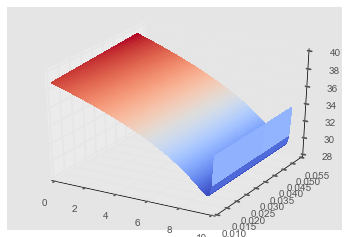

In [346]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

X_coord, Y_coord = np.meshgrid(alphas, l1_ratio)
surf = ax.plot_surface(X_coord, Y_coord, mse, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False);